# Persistent Homology: Improving the code a bit and more examples
Let us load the functions written earlier, with a change in the Reduce function, where we introduce the Low function, to hopefully reduce the computation time taken by the nonzero function. Furthermore, even though the value $k$ can be up to the amount of points, we are mostly interested in $k=3$ at least for now, for 2-dimensional shapes (to detect connected components and holes).

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from operator import itemgetter
import profile
import scipy.sparse as sps
import time

def Lower_Nbrs(V,E,u):
    #find all the neighbors v of vertex u in the neighborhood graph G=(V,E) 
    #that precede it (in whichever ordering the vertices are)
    return{v for v in V if u > v and ([u,v] in E or [v,u] in E)}

def VRcomplex(D,k,eps):
    #inputs: the set D of data points,and k is the max dimension desired for the simplices
    #(k=0 for vertices, k=1 for edges, k=2 for triangles, k=3 for tetrahedra...)
    #eps is the parameter for the size of the neighborhood
    #output: the corresponding VRcomplex and weights

    #stores weights
    weights = []
    
    #this creates the neighborhood graph and add its vertices and edges to the complex
    #add vertices to the complex
    nb_nodes = len(D)
    VRcomplex = [[j] for j in range(0,nb_nodes)]
    #add edges
    nb_edges = 0
    for i in range(0,nb_nodes):
        for j in range(i+1,nb_nodes):
            #this is O(nb_nodes^2)
            if np.linalg.norm(D[i]-D[j]) < eps:
                VRcomplex.append([i,j])
                weights.append(np.linalg.norm(D[i]-D[j]))
                nb_edges = nb_edges + 1
        
    for i in range(1,k):
        for simplex in [v for v in VRcomplex if len(v)==i+1]:
            N = set.intersection(*[Lower_Nbrs(range(0,nb_nodes),VRcomplex[nb_nodes:nb_nodes+nb_edges],u) for u in simplex])
            for n in N:
                VRcomplex.append(sorted(list(set.union({n},simplex)),key=int))
    
    return(VRcomplex,weights)

def PlotVRcomplex(D,complex):
    #take as input the data points and the output of VRcomplex and plots it
    
    nb_nodes = len(D)
    nb_edges = len([simplex for simplex in complex if len(simplex)==2])
    dim = len(D[0])
    
    if dim == 2:
        #draw and annotate nodes
        for i in range(0,nb_nodes):
            plt.plot(D[i,0],D[i,1],'ob')
            plt.annotate(i,(D[i,0],D[i,1]+0.05))
        
        #draw edges    
        for j in range(nb_nodes,nb_nodes+nb_edges):
            plt.plot([D[complex[j][0],0],D[complex[j][1],0]],[D[complex[j][0],1],D[complex[j][1],1]],'b')
        
        #draw surfaces
        idx = nb_nodes+nb_edges
        while idx<len(complex) and len(complex[idx])==3:
            #extract triangles, and sort them according to their x components
            trg = sorted(D[complex[idx]],key=itemgetter(0))
            a = (trg[0][1]-trg[2][1])/(trg[0][0]-trg[2][0])
            b = trg[0][1]-a*trg[0][0]
            plt.fill_between([trg[j][0] for j in range(3)],[trg[j][1] for j in range(3)],[trg[0][1],a*trg[1][0]+b,trg[2][1]],color='blue',alpha='0.5')
            idx = idx+1
        plt.axis([-1.5,1.5,-1.5,1.5])
        plt.gca().set_aspect('equal',adjustable='box')
    
    if dim == 3:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.set_aspect('equal')
        #draw and annotate nodes
        for i in range(0,nb_nodes):
            ax.scatter3D(D[i,0],D[i,1],D[i,2])
            label = '%d' % i
            ax.text(D[i,0],D[i,1]+0.05,D[i,2],label)
            
        #draw edges    
        for j in range(nb_nodes,nb_nodes+nb_edges):
            ax.plot3D([D[complex[j][0],0],D[complex[j][1],0]],[D[complex[j][0],1],D[complex[j][1],1]],[D[complex[j][0],2],D[complex[j][1],2]],'b')
        
        #draw surfaces
        idx = nb_nodes+nb_edges
        trg = []
        while idx<len(complex) and len(complex[idx])==3:
            #extract triangles
            trg.append(D[complex[idx]])
            idx = idx+1
        trgs = Poly3DCollection(trg)
        ax.add_collection3d(trgs)    
            
def BoundMatrix(complex,n):
    #take as input a complex given as a list of its simplices, and the dimension n such that we compute the (n-1)-boundary
    #which is given as a matrix with columns indexed by n-simplices
    
    nsimplex = [simplex for simplex in complex if len(simplex)==n]
    nbcols = len(nsimplex)
    n_1simplex = [simplex for simplex in complex if len(simplex)==n-1]
    nbrows = len(n_1simplex)
    
    B = np.zeros((nbrows,nbcols), dtype = np.uint8)
    for i in range(0,nbcols):
        simplex = nsimplex[i]
        for j in range(0,len(simplex)):
            n_1newsimplex = [x for x in simplex if x != simplex[j]]
            #over Z, we would use (-1)**j, but over F2 is good enough for us
            B[n_1simplex.index(n_1newsimplex),i] = 1 
    return B
            
def BarCode(C,k):
    #input: a complex C (C[0]) with its weights (C[1]) and the highest simplex dimension k
    #output: the intervals defining the bar codes, the transformation matrix, and the weights of the simplices
    
    complex = C[0]
    lenC0 = len(C[0])
    nb_nodes = len([simplex for simplex in complex if len(simplex)==1])
    edges = [simplex for simplex in complex if len(simplex)==2]
    n = nb_nodes*(nb_nodes-1)/2
    weights = np.zeros(lenC0)
    
    #computes the weight of every simplex in the complex C[0]
    cnt_simplex = 0
    for simplex in complex:
        maxweight = 0
        for i in range(0,len(simplex)):
            for j in range(i+1,len(simplex)):
                #recovers the index of the edge and thus the one of its weight
                idx = edges.index([simplex[i],simplex[j]])
                if C[1][idx] > maxweight:
                    maxweight = C[1][idx]
        weights[cnt_simplex] = maxweight
        cnt_simplex = cnt_simplex + 1
    
    complex_sorted = []
    nb_simplex = np.zeros(k+1,dtype=np.int32)
    Btot_reduced = np.zeros((lenC0,lenC0),dtype=np.int8)
    #Btot_reduced = sps.lil_matrix((lenC0,lenC0))
    Btrans = np.identity(lenC0,dtype=np.int8)
     
    #works on simplices per dimension
    for lgth in range(1,k+1):
        nb_simplex[lgth] = len([simplex for simplex in complex if len(simplex)==lgth])
        #lower and upper range that determine the positions of the k-simplices
        lr = sum(nb_simplex[0:lgth])
        ur = sum(nb_simplex[0:lgth+1])
        #total order on the simplices according to the weight function
        complex_sorted.extend([x for (y,x) in sorted(zip(weights[lr:ur],complex[lr:ur]))])    
        weights[lr:ur] = sorted(weights[lr:ur])
       
        if lgth > 1: 
            Btot_reduced[sum(nb_simplex[0:lgth-1]):lr,lr:ur],Btrans[lr:ur,lr:ur] = Reduce(BoundMatrix(complex_sorted[sum(nb_simplex[0:lgth-1]):ur],lgth))   
               
    intervals = []  
    for i in range(0,lenC0):
        if len(Btot_reduced[:,i].nonzero()[0]) == 0:
            intervals.append([i])
        else:
            lw_idx = max(Btot_reduced[:,i].nonzero()[0])
            if [lw_idx] in intervals:
                intervals[intervals.index([lw_idx])].append(i)
        
    return(intervals,Btrans,weights,complex_sorted)    

def PlotBarCode(BC,complex,weights,M,k,eps):
    #take as input a barcode BC,the complex,its weights, its transformation matrix M
    
    nb = [0]
    inter = []
    #plots ticks 
    ytickpos = []
    yticklabel = []
    cnt_tick = 0
    
    #find indices of "born" features
    idx = set(np.where(~(M-np.identity(len(M),dtype=np.int8)).any(axis=1))[0])

    #add eps to the weights
    weights = np.hstack([weights,eps])
    for i in range(1,k+1):
        nb.append(len([simplex for simplex in complex[0] if len(simplex)==i]))
        inter.append(idx.intersection(range(sum(nb[0:i]),sum(nb[0:i+1]))))
    
    cnt_bar = 0
    curr_lgt = 1
    next_lgt = 0
    #plots bar codes
    for i in range(0,len(BC)):
        if len(BC[i])==1:
            #add an explicit end of interval whose weight will be eps
            BC[i].append(len(complex[0]))
        next_lgt = [j for j in range(0,k-1) if BC[i][0] in inter[j]]
        #if len(next_lgt)=0 then this simplex is too high-dim
        if len(next_lgt)>0 and abs(weights[BC[i][0]]-weights[BC[i][1]]) > 0.01 and curr_lgt < k-1:
            #plots only bars which are long enough
            if next_lgt[0] == curr_lgt:
                #counting bars that are drawn
                cnt_bar = cnt_bar + 1
            else:
                curr_lgt = next_lgt[0]
                #plot ticks
                plt.plot([0,eps],[cnt_bar+1,cnt_bar+1],'k--')
                ytickpos.append(cnt_bar+1)
                yticklabel.append(cnt_tick)
                cnt_tick = cnt_tick + 1    
                cnt_bar = cnt_bar + 2
            plt.plot([weights[BC[i][0]],weights[BC[i][1]]],[cnt_bar,cnt_bar])
            
    plt.axis([0,eps,-0.5,cnt_bar+1])
    plt.yticks(ytickpos,yticklabel)
    plt.gca().xaxis.grid(True)

In [3]:
%load_ext Cython

In [4]:
%%cython

import numpy as np
cimport numpy as np
import cython 

def Low(np.ndarray[np.uint8_t, ndim = 1] col, int lgth):
    #take as input a matrix and a column
    #output the non-zero coefficient with the highest index (which is "the lowest" in that it's at the bottom)
    cdef int j
  
    for j in range((lgth-1),-1,-1):
        if col[j]==1:
            return j
    #if the column is the whole zero column, return -1    
    return -1    

def Reduce(np.ndarray[np.uint8_t, ndim =2] M):
    #take as input a matrix with coefficients in 0,1
    #output a reduced form with coefficients 0,1 such that low is injective
    cdef int nbrows,nbcols,i,j,rpt,ent
     
    nbrows = M.shape[0]
    nbcols = M.shape[1]
    
    transM = np.identity(nbcols,dtype=np.int8)
    
    #scan through columns
    for j in range(0,nbcols):
        #scan through previous columns
        rpt = 1
        while rpt == 1:
            ent = 0
            for i in range(0,j):
                if Low(M[:,i],nbrows)== Low(M[:,j],nbrows)>-1:
                    M[:,j] = (M[:,j] + M[:,i])%2
                    #keeps track of the column reduction
                    transM[i,j] = 1
                    #one reduction has been made
                    ent = 1
            #if no column reduction has been made, stop, otherwise do another round of reduction        
            if ent == 0:
                rpt = 0
               
    return(M,transM)

For 10 points, the previous code was requesting 10.4 secs, now we have 0.4 secs.

In [59]:
V1 = np.array([[ 1.16508412, -0.14546559],
       [ 0.86344447,  0.6411075 ],
       [ 0.15182166,  0.72103331],
       [-0.20763822,  1.15328936],
       [-1.20233783,  0.14636805],
       [-1.22126355, -0.17271477],
       [-0.45827422, -0.94028314],
       [ 0.29822157, -1.22591029],
       [ 0.57870246, -0.41342032],
       [ 0.74158809,  0.03530509]])

#value for the largest epsilon 
eps1 = 3
nbpts1 = len(V1)

#computes the corresponding complex
#the parameter 3 is for the highest dimension
obt_complex1 = VRcomplex(V1,3,eps1)

profile.run('BarCode(obt_complex1,nbpts1)')

         14220 function calls in 0.406 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        9    0.343    0.038    0.343    0.038 :0(Reduce)
      385    0.001    0.000    0.001    0.000 :0(append)
        1    0.000    0.000    0.406    0.406 :0(exec)
       10    0.000    0.000    0.000    0.000 :0(extend)
       20    0.000    0.000    0.000    0.000 :0(hasattr)
     3084    0.012    0.000    0.012    0.000 :0(index)
     8615    0.014    0.000    0.014    0.000 :0(len)
      129    0.000    0.000    0.000    0.000 :0(max)
      514    0.002    0.000    0.002    0.000 :0(nonzero)
        1    0.000    0.000    0.000    0.000 :0(setprofile)
       20    0.001    0.000    0.001    0.000 :0(sorted)
       38    0.000    0.000    0.000    0.000 :0(sum)
       22    0.000    0.000    0.000    0.000 :0(zeros)
       10    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:996(_handle_fromlist)
        9    0.005

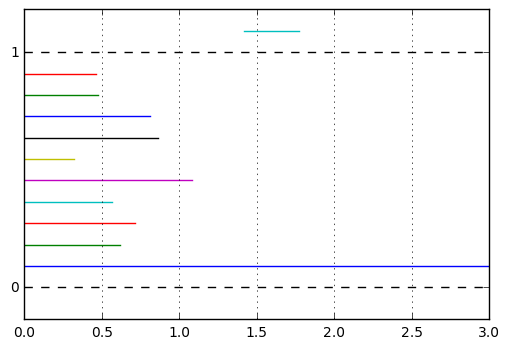

In [65]:
BC1,Mtrans1,weightsV1,sortedV1 = BarCode(obt_complex1,nbpts1)

PlotBarCode(BC1,obt_complex1,weightsV1,Mtrans1,3,eps1)
plt.show()

Let us try with more points and see how faster the code is as compared with before.

         762081 function calls in 1011.848 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       13  999.630   76.895  999.636   76.895 :0(Reduce)
    16383    0.028    0.000    0.028    0.000 :0(append)
        1    0.000    0.000 1011.848 1011.848 :0(exec)
       14    0.000    0.000    0.000    0.000 :0(extend)
       28    0.000    0.000    0.000    0.000 :0(hasattr)
   122865    6.560    0.000    6.560    0.000 :0(index)
   475112    0.691    0.000    0.691    0.000 :0(len)
     8191    0.033    0.000    0.033    0.000 :0(max)
    24574    2.332    0.000    2.332    0.000 :0(nonzero)
        1    0.000    0.000    0.000    0.000 :0(setprofile)
       28    0.029    0.001    0.029    0.001 :0(sorted)
       54    0.001    0.000    0.001    0.000 :0(sum)
       30    0.004    0.000    0.004    0.000 :0(zeros)
       14    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:996(_handle_fromlist)
       14    0

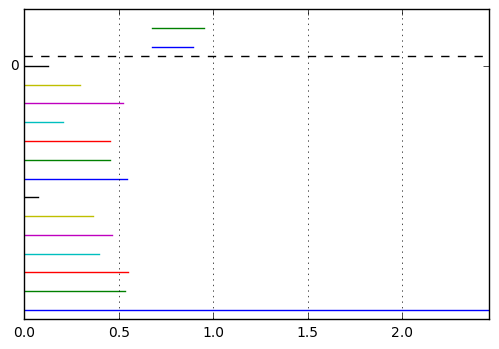

In [9]:
nbpts = 14
xcoord = np.hstack([-0.7+0.6*np.cos(np.linspace(0,2*math.pi,nbpts/2)),0.7+0.6*np.cos(np.linspace(0,2*math.pi,nbpts/2))])
ycoord = np.hstack([0.4*np.sin(np.linspace(0,2*math.pi,nbpts/2)),0.4*np.sin(np.linspace(0,2*math.pi,nbpts/2))])

C = np.array([xcoord,ycoord])
              

Cn = C + np.random.uniform(-0.1,0.1,(2,nbpts))
V = Cn.transpose()

#value for the largest epsilon 
eps = 3

#computes the corresponding complex
obt_complex = VRcomplex(V,nbpts,eps)
profile.run('BC,Mtrans,weightsV,sortedV=BarCode(obt_complex,nbpts)')

PlotBarCode(BC,obt_complex,weightsV,Mtrans,nbpts,eps)
plt.show()

In [10]:
1011/60

16.85

All right, so from 74 mins, we get to 16 mins, which is a good improvement, but it is still quite slow.
However, as the plot shows, and as already argued before, the relevant data for a 2-dimensional shape is really happening for $H_0$ and $H_1$, so we do not need such high values of $k$ as the number of points. Keeping $k=3$ should do the job. Let us try this.

         30179 function calls in 0.854 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.692    0.346    0.692    0.346 :0(Reduce)
     1470    0.003    0.000    0.003    0.000 :0(append)
        1    0.000    0.000    0.854    0.854 :0(exec)
        3    0.000    0.000    0.000    0.000 :0(extend)
        6    0.000    0.000    0.000    0.000 :0(hasattr)
     8554    0.037    0.000    0.037    0.000 :0(index)
    17166    0.031    0.000    0.031    0.000 :0(len)
       91    0.000    0.000    0.000    0.000 :0(max)
     1561    0.013    0.000    0.013    0.000 :0(nonzero)
        1    0.000    0.000    0.000    0.000 :0(setprofile)
        6    0.001    0.000    0.001    0.000 :0(sorted)
       10    0.000    0.000    0.000    0.000 :0(sum)
        8    0.001    0.000    0.001    0.000 :0(zeros)
        3    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:996(_handle_fromlist)
        2    0.005

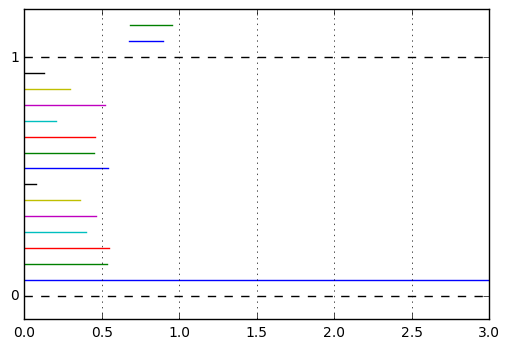

In [67]:
V = np.array(
[[-0.05879229, -0.05155091],
 [-0.40704194,  0.37172565],
 [-0.95470705,  0.37999599],
 [-1.23259153,  0.09594535],
 [-1.07392086, -0.34083625],
 [-0.39792604, -0.32068476],
 [-0.12680219, -0.08193659],
 [ 1.22625316, -0.04893682],
 [ 0.90590517,  0.41383319],
 [ 0.36466423,  0.42821966],
 [ 0.11700953,  0.04995873],
 [ 0.35947414, -0.4122592 ],
 [ 1.02021132, -0.26005116],
 [ 1.20350012,  0.07474682]]
)

eps = 3

k = 3
#computes the corresponding complex
obt_complex = VRcomplex(V,k,eps)
profile.run('BC,Mtrans,weightsV,sortedV=BarCode(obt_complex,k)')

PlotBarCode(BC,obt_complex,weightsV,Mtrans,k,eps)
plt.show()

So this seems to be working fine now. We indeed detect the 2 holes, and this is done in 0.8 secs for 14 points, this looks more reasonable. Also the function that plots the bar codes was slightly modified, so that features "born" at $k=3$ are not shown.

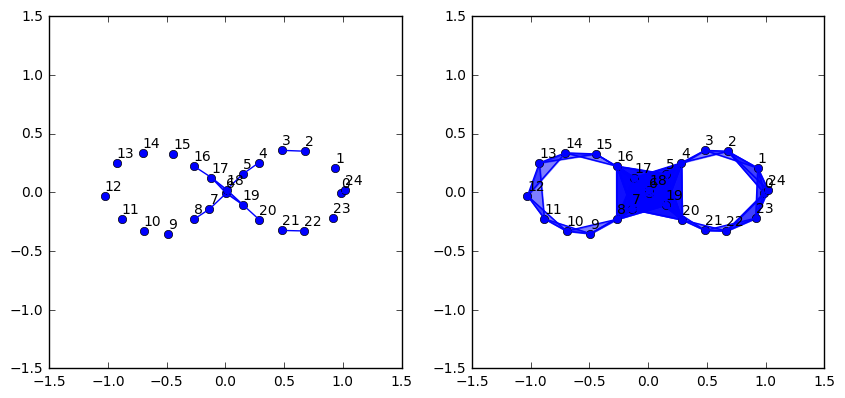

time taken in secs 0.044363975524902344


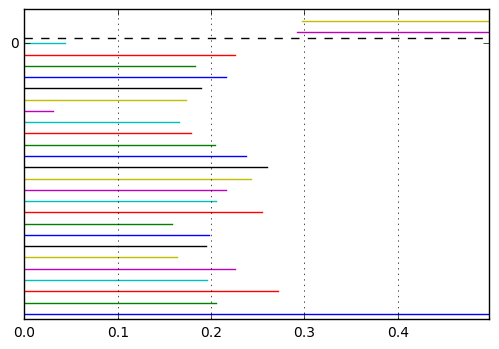

In [106]:
nbpts = 25
t = np.linspace(0,2*math.pi,num=nbpts)
#lemniscate
xcoord = np.cos(t)/(np.sin(t)**2+1)
ycoord = np.cos(t)*np.sin(t)/(np.sin(t)**2+1)

C = np.array([xcoord,ycoord])
              

Cn = C + np.random.uniform(-0.03,0.03,(2,nbpts))
V = Cn.transpose()

#value for the largest epsilon 
eps = 0.5

#computes the corresponding complex
k = 3
obt_complex = VRcomplex(V,k,eps)

#plots the complex
plt.figure(1,figsize=(10,10))
plt.subplot(121)
PlotVRcomplex(V,VRcomplex(V,k,0.2)[0])
plt.subplot(122)
PlotVRcomplex(V,VRcomplex(V,k,0.5)[0])
plt.show()

#tic
t = time.time()
#computes its bar codes
BC,Mtrans,weightsV,sortedV = BarCode(obt_complex,k)
#toc 
elapsed = (time.time() - t)
print('time taken in secs',elapsed)

#plots the bar codes
PlotBarCode(BC,obt_complex,weightsV,Mtrans,k,eps)
plt.show()

So we see one connected components and two holes. This looks fine.

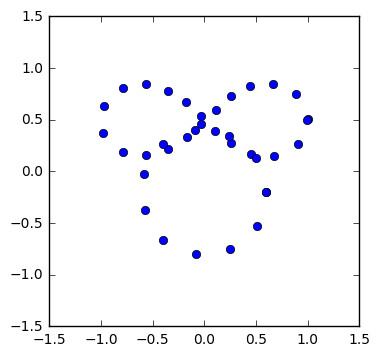

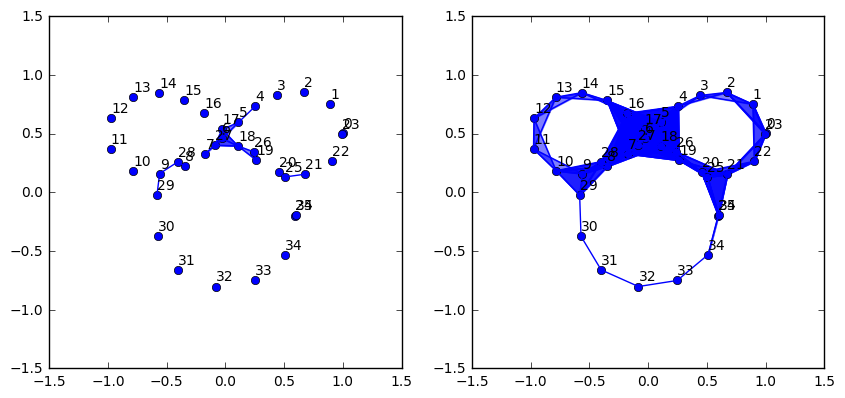

time taken in secs 0.18784284591674805


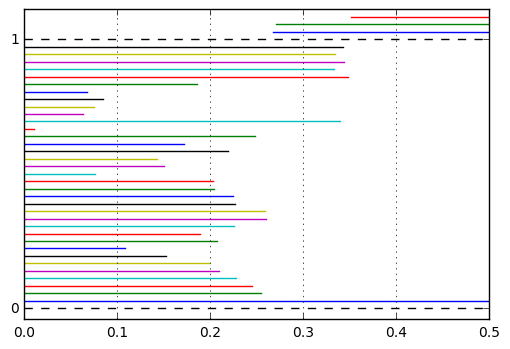

In [68]:
nbpts = 24
t = np.linspace(0,2*math.pi,num=nbpts)
#lemniscate
xlem = np.cos(t)/(np.sin(t)**2+1)
ylem = np.cos(t)*np.sin(t)/(np.sin(t)**2+1)
xcirc = 0.6*np.cos(np.linspace(0,2*math.pi,nbpts/2))
ycirc = 0.6*np.sin(np.linspace(0,2*math.pi,nbpts/2))

xcoord = np.hstack([xlem,xcirc])
ycoord = np.hstack([0.5+ylem,-0.2+ycirc])

C = np.array([xcoord,ycoord])
Cn = C + np.random.uniform(-0.01,0.01,(2,nbpts+int(nbpts/2)))

plt.plot(Cn[0],Cn[1],'ob') 
plt.axis([-1.5,1.5,-1.5,1.5])
plt.gca().set_aspect('equal',adjustable='box')
plt.show()

V = Cn.transpose()

#value for the largest epsilon 
eps = 0.5

#computes the corresponding complex
k = 3
obt_complex = VRcomplex(V,k,eps)

#plots the complex
plt.figure(1,figsize=(10,10))
plt.subplot(121)
PlotVRcomplex(V,VRcomplex(V,k,0.2)[0])
plt.subplot(122)
PlotVRcomplex(V,VRcomplex(V,k,0.5)[0])
plt.show()

#tic
t = time.time()
#computes its bar codes
BC,Mtrans,weightsV,sortedV = BarCode(obt_complex,k)
#toc 
elapsed = (time.time() - t)
print('time taken in secs',elapsed)

#plots the bar codes
PlotBarCode(BC,obt_complex,weightsV,Mtrans,k,eps)
plt.show()

We see the persistence of one bar till past 0.4 in $H_0$, this gives us the connected component part. We also see 3 bars in $H_1$ corresponding to 3 holes. Two bars are longer, corresponding to the "small" holes (we can see on the figure that they are much more emphasized than the large circle). Let us look at a 3-dimensional example.

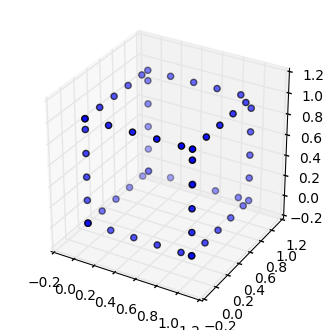

In [29]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect('equal')

nbpts = 5
t = np.linspace(0,0.9,nbpts).tolist()
zero = np.zeros(nbpts).tolist()
one = np.ones(nbpts).tolist()
x = np.array(t+zero+zero+t+one+one+t+zero+t+one+one+zero)
y = np.array(zero+t+zero+zero+t+zero+one+t+one+one+t+one)
z = np.array(zero+zero+t+one+zero+t+zero+one+one+t+one+t)
ax.scatter3D(x,y,z)
plt.show()


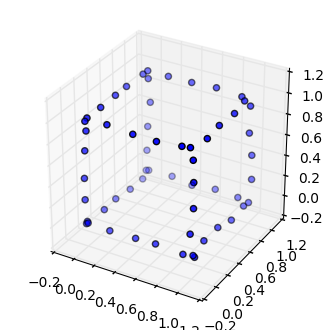

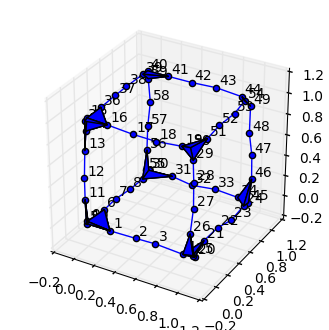

time taken in secs 0.3854799270629883


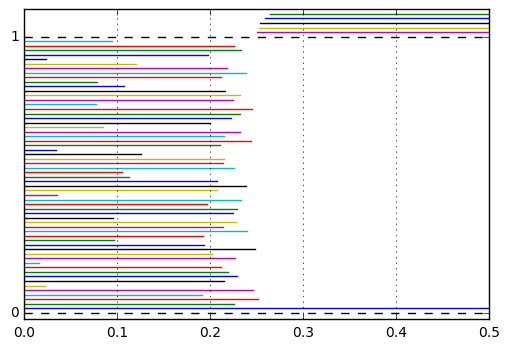

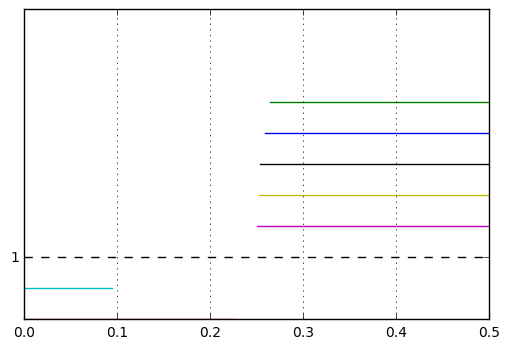

In [70]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect('equal')

nbpts = 5
t = np.linspace(0,0.9,nbpts).tolist()
zero = np.zeros(nbpts).tolist()
one = np.ones(nbpts).tolist()
x = np.array(t+zero+zero+t+one+one+t+zero+t+one+one+zero)
y = np.array(zero+t+zero+zero+t+zero+one+t+one+one+t+one)
z = np.array(zero+zero+t+one+zero+t+zero+one+one+t+one+t)
C = np.array([x,y,z])
Cn = C + np.random.uniform(-0.02,0.02,(3,12*nbpts))
ax.scatter3D(Cn[0],Cn[1],Cn[2])
plt.show()

V = Cn.transpose()

#value for the largest epsilon 
eps = 0.5

#computes the corresponding complex
k = 3
obt_complex = VRcomplex(V,k,eps)

#plots the complex
PlotVRcomplex(V,VRcomplex(V,k,0.3)[0])
plt.show()

#tic
t = time.time()
#computes its bar codes
BC,Mtrans,weightsV,sortedV = BarCode(obt_complex,k)
#toc 
elapsed = (time.time() - t)
print('time taken in secs',elapsed)

#plots the bar codes
PlotBarCode(BC,obt_complex,weightsV,Mtrans,k,eps)
plt.show()

#zoom into the bar codes
PlotBarCode(BC,obt_complex,weightsV,Mtrans,k,eps)
plt.ylim(60, 70)
plt.show()

We zoom into the $H_1$ part of the bar codes, and we see 5 bars. This describes 5 holes corresponding to the 5 faces of an unfolded cube. We try another 3-dimensional example.

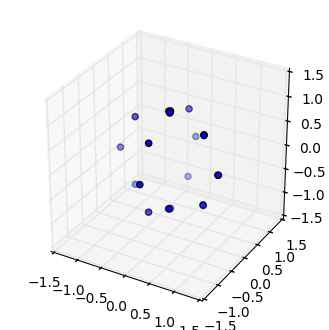

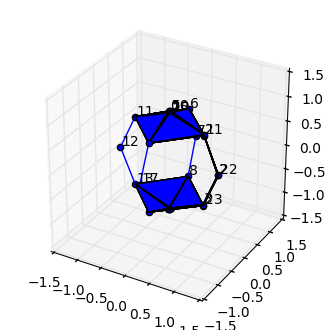

time taken in secs 0.6380722522735596


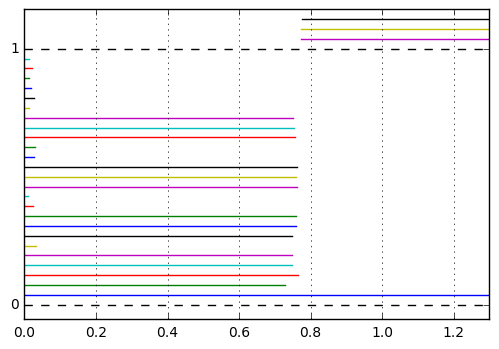

In [72]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect('equal')

nbpts = 5

u = np.linspace(0, 2 * np.pi, nbpts)
v = np.linspace(0, np.pi, nbpts)

x =  np.outer(np.cos(u), np.sin(v))
y =  np.outer(np.sin(u), np.sin(v))
z =  np.outer(np.ones(np.size(u)), np.cos(v))

C = np.array([np.hstack(x),np.hstack(y),np.hstack(z)])
Cn = C + np.random.uniform(-0.02,0.02,(3,nbpts*nbpts))
ax.scatter3D(Cn[0],Cn[1],Cn[2])

plt.show()

V = Cn.transpose()

#value for the largest epsilon 
eps = 1.3

#computes the corresponding complex
k = 4
obt_complex = VRcomplex(V,k,eps)

#plots the complex
PlotVRcomplex(V,VRcomplex(V,k,eps)[0])
plt.show()

#tic
t = time.time()
#computes its bar codes
BC,Mtrans,weightsV,sortedV = BarCode(obt_complex,k)
#toc
elapsed = (time.time() - t)
print('time taken in secs',elapsed)

#plots the bar codes
PlotBarCode(BC,obt_complex,weightsV,Mtrans,k,eps)
plt.show()


Even though we gave the parameterization of the sphere, the no of points is such that for $\epsilon=1.3$, we actually two "full faces" as shown on the figure, with indeed 3 holes.

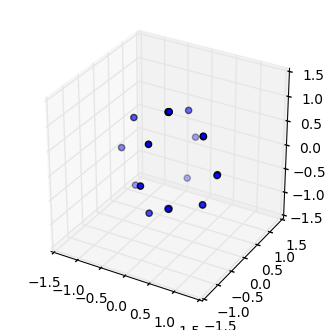

no of simplices 5711


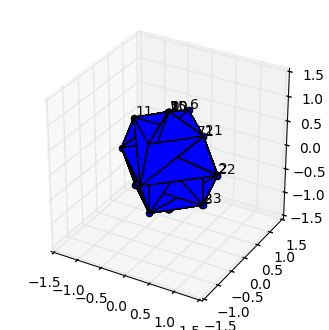

time taken in mins 0.7104663888613383


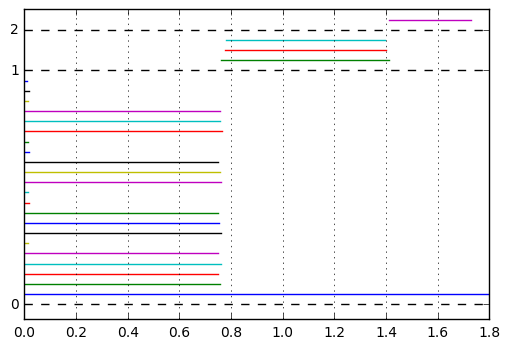

In [73]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect('equal')

nbpts = 5

u = np.linspace(0, 2 * np.pi, nbpts)
v = np.linspace(0, np.pi, nbpts)

x =  np.outer(np.cos(u), np.sin(v))
y =  np.outer(np.sin(u), np.sin(v))
z =  np.outer(np.ones(np.size(u)), np.cos(v))

C = np.array([np.hstack(x),np.hstack(y),np.hstack(z)])
Cn = C + np.random.uniform(-0.02,0.002,(3,nbpts*nbpts))
ax.scatter3D(Cn[0],Cn[1],Cn[2])

plt.show()

V = Cn.transpose()

#value for the largest epsilon 
eps = 1.8

#computes the corresponding complex
k = 4
obt_complex = VRcomplex(V,k,eps)
print('no of simplices',len(obt_complex[0]))

#plots the complex
PlotVRcomplex(V,VRcomplex(V,k,eps)[0])
plt.show()

#tic
t = time.time()
#computes its bar codes
BC,Mtrans,weightsV,sortedV = BarCode(obt_complex,k)
#toc
elapsed = (time.time() - t)/60
print('time taken in mins',elapsed)

#plots the bar codes
PlotBarCode(BC,obt_complex,weightsV,Mtrans,k,eps)
plt.show()


We notice a bit after 1.4 the appearance of a higher dimensional feature. However the persistence of the other bars suggests that this shape is mostly separate points (the longest bars are in $H_0$), then there are 3 holes (corresponding to the drawing at $\epsilon$=1.3).

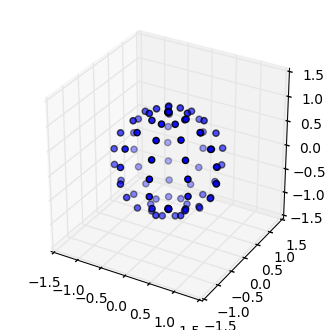

no of simplices 5863


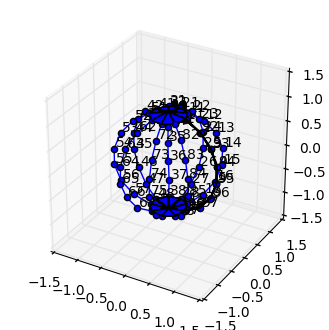

time taken in mins 0.58826162815094


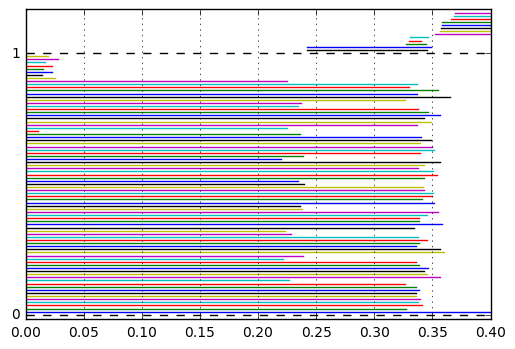

In [12]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect('equal')

nbpts = 10

u = np.linspace(0, 2 * np.pi, nbpts)
v = np.linspace(0, np.pi, nbpts)

x =  np.outer(np.cos(u), np.sin(v))
y =  np.outer(np.sin(u), np.sin(v))
z =  np.outer(np.ones(np.size(u)), np.cos(v))

C = np.array([np.hstack(x),np.hstack(y),np.hstack(z)])
Cn = C + np.random.uniform(-0.02,0.002,(3,nbpts*nbpts))
ax.scatter3D(Cn[0],Cn[1],Cn[2])

plt.show()

V = Cn.transpose()

#value for the largest epsilon 
eps = 0.4

#computes the corresponding complex
k = 3

#tic
t = time.time()
obt_complex = VRcomplex(V,k,eps)
print('no of simplices',len(obt_complex[0]))

#plots the complex
PlotVRcomplex(V,VRcomplex(V,k,eps)[0])
plt.show()

#computes its bar codes
BC,Mtrans,weightsV,sortedV = BarCode(obt_complex,k)
#toc
elapsed = (time.time() - t)/60
print('time taken in mins',elapsed)

#plots the bar codes
PlotBarCode(BC,obt_complex,weightsV,Mtrans,k,eps)
plt.show()

#zoom into the bar codes
#PlotBarCode(BC,obt_complex,weightsV,Mtrans,k)
#plt.ylim(60, 70)
#plt.show()

Of course we would like the Betti numbers of the sphere to be detected but actually, we can see from the above figure that the parametrization is not uniform, there are more points accumulating around both poles.